# Welding Defects Segmentation

#### This project focuses on segmenting welding defects using image segmentation techniques. The main goal is to detect and classify welding defects in real-time using a camera feed and a segmentation model.  

#### The dataset used is the **Welding Defects Dataset** from Roboflow, which includes 10 defect classes plus a background class. Due to its size, the dataset is not included here, but you can access it via this link: [Welding Defects Dataset](https://universe.roboflow.com/test-ulmj1/defect-detection-renamed-classes/dataset/4).

---

## 1. Setup

First, I install or upgrade **fastai** (to ensure we have the latest version), then import the main libraries:  
- `fastai.vision.all` for the U-Net and the DataBlock stuff.  
- `matplotlib` for plotting.  
- `functools.partial` to create a quick partial function for our multi-class accuracy.  


In [ ]:
!pip install fastai --upgrade

### IMPORTS

In [1]:
import os
from pathlib import Path
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

### PATHS 

In [2]:
path = Path('dataset')
train_img_path = path/'train'/'images'
train_mask_path = path/'train'/'masks'
valid_img_path = path/'valid'/'images'
valid_mask_path = path/'valid'/'masks'
test_img_path  = path/'test'

train_imgs = get_image_files(train_img_path)
train_masks = get_image_files(train_mask_path)
valid_imgs = get_image_files(valid_img_path)
valid_masks = get_image_files(valid_mask_path)

print(f"Train images: {len(train_imgs)} | Train masks: {len(train_masks)}")
print(f"Valid images: {len(valid_imgs)} | Valid masks: {len(valid_masks)}")


Train images: 8343 | Train masks: 1503
Valid images: 520 | Valid masks: 54


###  Defining Classes (Codes) and Helper Functions
The dataset has 10 defects plus a background class (ID = 0). I list them in codes so fastai knows we have 11 total classes:

In [3]:
codes = [
    "background",
    "Burn-through",
    "Crack",
    "Crater",
    "Incomplete penetration",
    "Overflow",
    "Porosity",
    "Spatter",
    "Undercut",
    "Welding line",
    "irregular_weld_Line"
]

def mask_for_image(img_file):
    #each image file has a corresponding mask with .png extension
    return img_file.parent.parent/'masks'/(img_file.stem + '.png')

def valid_pair(f):
    #checks if the mask really exists for that image
    return (f.parent.parent/'masks'/(f.stem + '.png')).exists()

filtered_train_imgs = [f for f in train_imgs if valid_pair(f)]
filtered_valid_imgs = [f for f in valid_imgs if valid_pair(f)]


### Building the DataBlock
#### I have used RandomSplitter because it’s a quick way to divide the dataset into training and validation sets. The seed (42) makes sure the split is always the same, so we can repeat the training and get consistent results every time.


- MaskBlock(codes=codes) ensures fastai knows we have 11 distinct labels (0..10).
-  aug_transforms(size=256) resizes and applies standard data augmentations.
- bs=4 is the batch size.

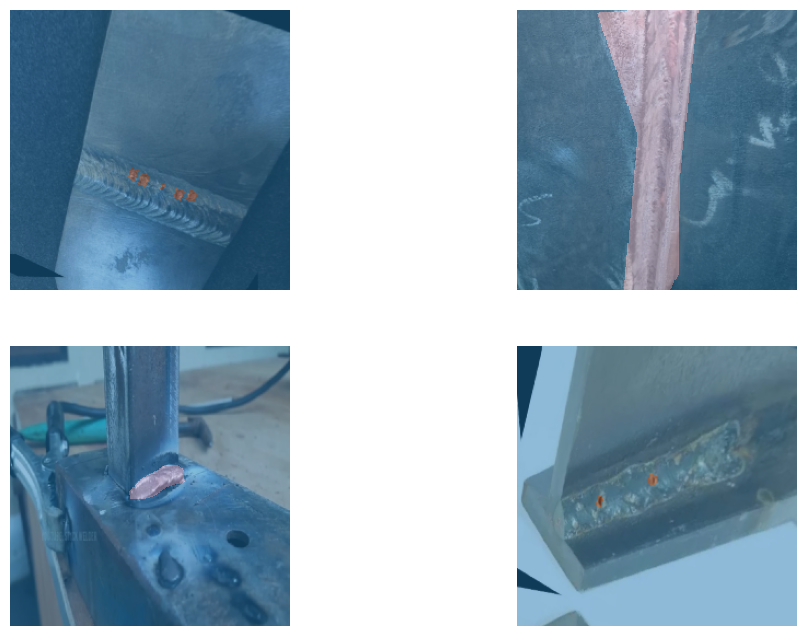

In [4]:
seg_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=lambda x: filtered_train_imgs,   # the images that actually have masks
    get_y=mask_for_image,
    splitter=RandomSplitter(seed=42),
    batch_tfms=[*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
)

dls = seg_block.dataloaders(train_img_path, bs=4)
dls.show_batch(max_n=4, figsize=(12,8))


### Training Approach #1: Multi-Class Accuracy
- Accuracy here means the fraction of pixels labeled correctly (including background). This can sometimes be misleading if there’s a lot of background, but it’s a good first step.

### Set up the Learner

In [5]:
acc_metric = partial(accuracy, axis=1)
learn = unet_learner(dls, resnet34, metrics=acc_metric)


#### We can use fastai’s lr_find() to get a suggested learning rate. 

SuggestedLRs(valley=0.00010964782268274575)


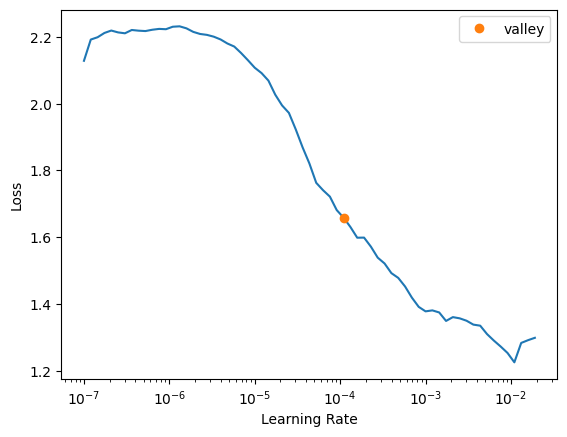

In [7]:
lr_suggest = learn.lr_find()
print(lr_suggest) 


### Fit One Cycle (First Round)

In [8]:
learn.fit_one_cycle(10, 0.000275)

epoch,train_loss,valid_loss,accuracy,time
0,0.426558,0.380678,0.909097,15:15
1,0.426284,0.371978,0.908699,15:18
2,0.417904,0.373974,0.908631,15:44
3,0.350206,0.329454,0.909806,15:51
4,0.334358,0.294700,0.921045,15:37
5,0.281462,0.268216,0.913365,15:15
6,0.253604,0.208213,0.934078,15:15
7,0.199757,0.197244,0.936303,15:22
8,0.183616,0.184560,0.938219,16:16
9,0.184687,0.181364,0.939524,15:47


## Results of the first round of training:
- Loss going down: The train_loss drops from around 0.42 to 0.18, so the model is definitely learning.
- Validation accuracy creeps up from ~0.90 to ~0.94 by the end. That suggests the model is getting better at labeling pixels correctly (including background). 
- By epoch 6, you see a big jump where train_loss goes to ~0.25 and valid_loss to ~0.20, which is quite a drop—likely the model “found” better weights.
- The final accuracy around 0.9395 is good. This means 93–94% of all pixels match their ground truth.

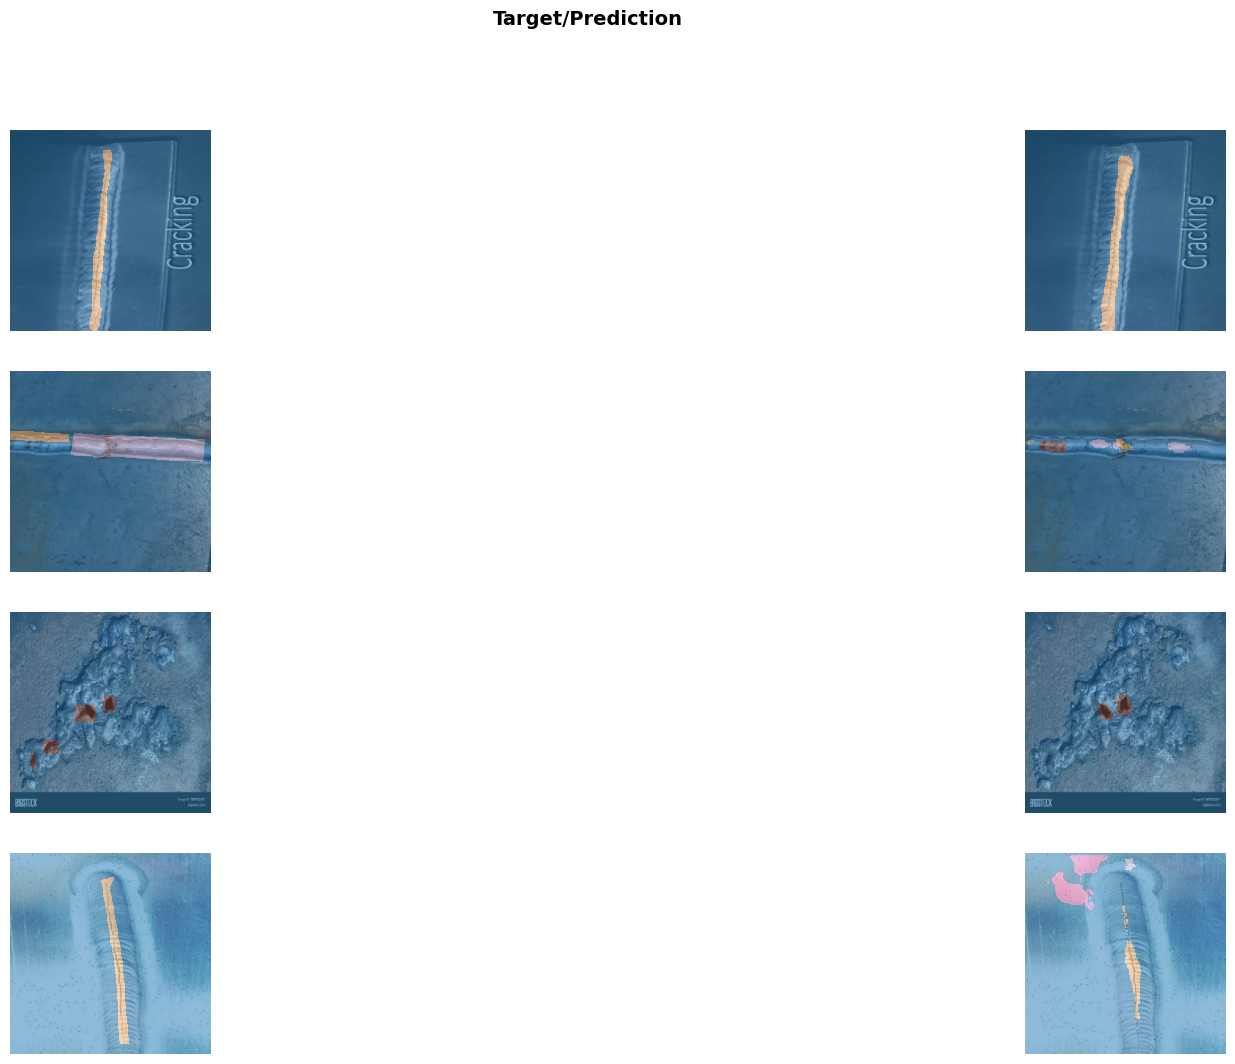

In [9]:
learn.show_results(max_n=4, figsize=(24,12))


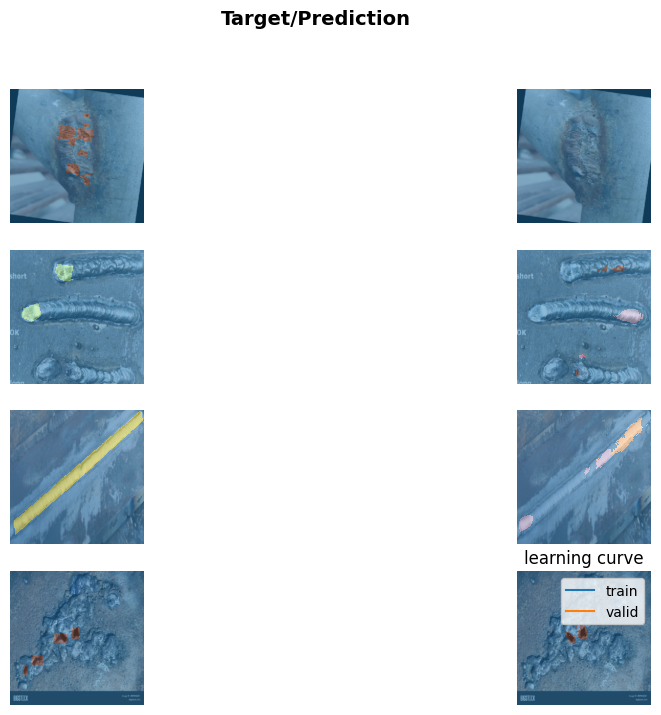

In [10]:
learn.show_results(max_n=4, figsize=(12,8))
learn.recorder.plot_loss()
plt.show()


### Second Round of Training with lower learning rate

In [11]:
learn.fit_one_cycle(10, 0.000275/4)


epoch,train_loss,valid_loss,accuracy,time
0,0.188417,0.178761,0.940790,15:39
1,0.179624,0.199049,0.934101,15:19
2,0.179314,0.172090,0.942436,15:16
3,0.157445,0.175598,0.941049,15:19
4,0.141340,0.153443,0.945063,15:20
5,0.133537,0.142297,0.948959,16:00
6,0.132301,0.134833,0.950856,15:36
7,0.117628,0.129607,0.952773,15:15
8,0.119440,0.131453,0.952923,15:17
9,0.109153,0.131876,0.952939,15:22


### Results of the second round of training:
- We lowered the LR to 0.000275/4, allowing the model to refine its parameters without big updates.
- The final accuracy edges up toward 0.95+, so it’s improving.
- The train_loss and valid_loss are both close and keep decreasing. That’s a good sign there’s not a huge overfit.

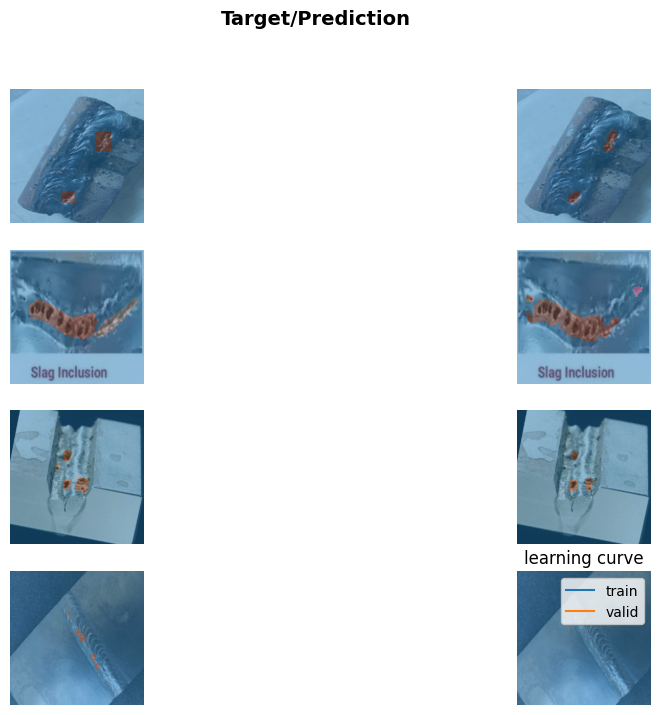

In [13]:
learn.show_results(max_n=4, figsize=(12,8))
learn.recorder.plot_loss()
plt.show()

### Training Approach #2: Custom Multi-Class Dice Metric

Dice (similar to an F1 score for segmentation) can be more informative about overlap, especially if we have classes with small areas.

In [14]:
def dice_multiclass(preds, targs, eps=1e-6):
    """
    preds: (batch, n_classes, h, w)
    targs: (batch, 1, h, w)
    Returns the average Dice across all classes.
    """
    n_classes = preds.shape[1]
    pred_mask = preds.argmax(dim=1)
    targs = targs.squeeze(1)
    dice_scores = []
    for c in range(n_classes):
        p = (pred_mask == c)
        t = (targs == c)
        intersection = (p & t).sum()
        union = p.sum() + t.sum()
        dice = (2. * intersection + eps) / (union + eps)
        dice_scores.append(dice)
    return torch.mean(torch.stack(dice_scores).float())


In [15]:
learn_dice = unet_learner(dls, resnet34, metrics=[acc_metric, dice_multiclass])


In [19]:
learn_dice.fit_one_cycle(10, 0.000275)


epoch,train_loss,valid_loss,accuracy,dice_multiclass,time
0,0.498482,0.495425,0.908187,0.675530,15:06
1,0.399910,0.454364,0.909853,0.677682,15:08
2,0.397474,0.349188,0.909962,0.658730,15:07
3,0.336253,0.321960,0.913232,0.667365,15:15
4,0.326231,0.287289,0.918721,0.654186,16:04
5,0.275614,0.244126,0.930806,0.680771,16:03
6,0.238014,0.204110,0.935684,0.660748,16:04
7,0.206357,0.188953,0.936016,0.623915,15:50
8,0.158885,0.174646,0.940666,0.662341,15:50
9,0.178563,0.176899,0.940876,0.647781,15:32


### Results:
- Accuracy still ~0.94 at the end.
- Dice is around ~0.64–0.68. That might seem lower, but Dice is more sensitive to class overlap. If there’s a lot of background vs small defect areas, the model can easily get high accuracy by labeling background correctly, but the Dice metric will reveal it’s not perfect at capturing every small region.

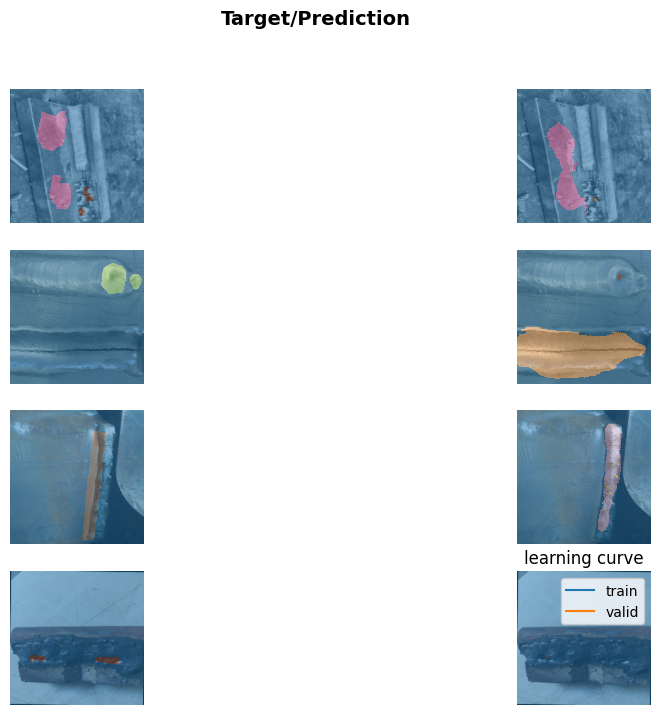

In [20]:
learn_dice.show_results(max_n=4, figsize=(12,8))
learn_dice.recorder.plot_loss()
plt.show()

## Conclusion
- Accuracy climbs to about 0.95–0.96, indicating the model is labeling a large portion of pixels correctly.
- Dice around 0.65–0.70 shows that while the model is decent overall, it struggles with small or tricky classes .
- Each additional training cycle at a lower learning rate tends to refine the model further, so you see some improvement in accuracy (and in the visual shape of the predicted masks).
- The training curves (plot_loss) show our training and validation losses decrease, but not drastically diverging, which is good (less risk of overfitting).
- In the sample “Target/Prediction” overlays, you can see that the background is usually correct (blueish overlay), and the colored defects align well with the actual defect areas



In [21]:
learn.save('my_welding_model')

Path('models/my_welding_model.pth')

In [22]:
learn_dice.save('my_welding_model_dice')

Path('models/my_welding_model_dice.pth')